# <center> 🏋‍♂️ Trainer практика 🛠

В этой практике вам предстоит обучить нейронную сеть для перевода с языка жестов на английский, применяя ранее изученные фишки Trainer из Lightning и залогировать метрики из Torchmetrics.

Важно!: Решите сначала практику 2.1 🥸 - так будет легче, так как данный урок основывается на ней.

Вам дан ноутбук с обучением простой свёрточной нейросети, реализованной на чистом PyTorch, которую необходимо перенести на PyTorch Ligthning и обучить её с помощью Trainer, выполнив все условия.

Вам необходимо сдать файл с расширением любое_имя.py в котором:

**Основное задание (5 баллов):**

* Будет загрузка датасета
* Создание LightningDataModule
* Создание LightningModule
* Добавлены 2 метрики (для train, val отдельно) из Torchmetrics. Например,F-Beta и ROC-AUC
* Обучение модели с помощью Trainer
* Используйте, как минимум 2 callback'а в Trainer. Например, EarlyStopping, ModelCheckpoint
* Сохраните веса модели
* Запуск инференса модели на одном образце из теста

**Дополнительное задание (2 балла):**

Напишите свою метрику, которой нет в Tochmetrics, например False discovery rate, формула выглядит так:

<img src='https://i.imgur.com/pJgq8Bz.png' align='center'>

The FDR is the rate that features called significant are truly null. An FDR of 5% means that, among all features called significant, 5% of these are truly null. false discovery rate (FDR) is a method of conceptualizing the rate of type I errors in null hypothesis testing when conducting multiple comparisons. FDR-controlling procedures are designed to control the FDR, which is the expected proportion of "discoveries" (rejected null hypotheses) that are false (incorrect rejections of the null). 

The false discovery rate difference metric calculates the amount of false positive transactions as a percentage of all transactions with a positive outcome.

- FP — False Positives
- TP — True Positives
- FDR = 0 означает, что нет ложных положительных срабатываний (идеальный случай).
- Подходит для задач с несбалансированными классами или когда ложные срабатывания критичны.


И добавьте ее в модель, для логирования 🤗


  
Файл должен запускаться командой `python любое_имя.py` и отрабатывать до конца без падений.

__What is FDR?__
In summary,

- P-value: Probability of observing the data (or more extreme) under the null hypothesis.

- Q-value: Adjusted p-value that accounts for multiple comparisons, controlling FDR.

- FDR: A rate, not a single value, controlling the proportion of false positives among all significant findings.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import time
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils.data as data


import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
torch.cuda.is_available()

True

# Загружаем датасет Sign Language MNIST

Датасет представляет из себя 2 CSV файла - трэйн и тест сплиты. 
Каждая запись представляет из себя: 
* метку (номер буквы в алфавите)
* значения каждого из 780 пикселей изображения.

<img src="https://i.imgur.com/aF6eCw4.png" align="left" />

In [16]:
%%capture
# Для запуска в колаб
# !mkdir ../data/
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/sign_mnist_train.csv.zip
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/sign_mnist_test.csv.zip
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/amer_sign2.png
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/amer_sign3.png
# !wget -P ../data https://github.com/a-milenkin/ml_instruments/raw/refs/heads/main/data/american_sign_language.PNG

!unzip ../data/sign_mnist_train.csv.zip -d ../data/
!unzip ../data/sign_mnist_test.csv.zip -d ../data/

In [ ]:
train = pd.read_csv('../data/sign_mnist_train.csv')
test = pd.read_csv('../data/sign_mnist_test.csv')

In [18]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
test.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222


## Определяем Pytorch Dataset and Dataloader:



In [ ]:
class SignLanguageDataset(data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
        

In [7]:
transforms4train = transforms.Compose([
        #transforms.Normalize(159, 40),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
]) 

In [8]:
train_dataset = SignLanguageDataset(train, transform=transforms4train)
test_dataset = SignLanguageDataset(test)

In [9]:
len(train_dataset), len(test_dataset)

(27455, 7172)

In [10]:
train_loader = data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)

### Посмотрим как выглядит одно изображение из трэйна

In [11]:
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

In [12]:
trainiter = iter(train_loader)
img, label = next(trainiter)
print(img.shape)

torch.Size([200, 1, 28, 28])


tensor(7)


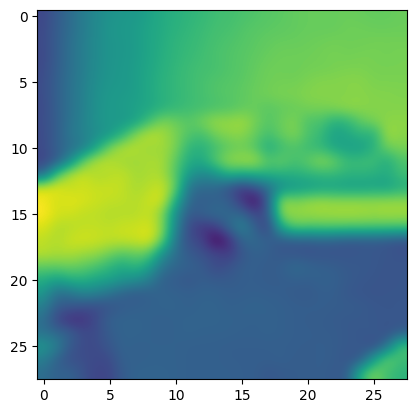

In [13]:
show_img(img[0], label[0])

In [14]:
def calc_out_size(img_size, kernel_size, stride=1, padding=1, dilation=1 ):
    out_size = ((img_size + 2 * padding - (dilation * (kernel_size - 1) + 1 )) / stride) + 1
    return int(out_size)

In [15]:
calc_out_size(28, 3)

28

## Напишем простую сверточную нейросеть и обучим её:

In [18]:
class MyConvNet(nn.Module):
    
    def __init__(self, stride=1, dilation=1, n_classes=25):
        
        super(MyConvNet, self).__init__()
        
        self.stride = stride
        self.dilation = dilation
        self.n_classes = n_classes
        
        self.block1 = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
        )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
    
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x

In [19]:
model = MyConvNet()
model

MyConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=100, out_features=25, bias=True)
)

In [20]:
# Проверяем
sample_batch = torch.ones(20, 1, 28, 28)
print(model.block1(sample_batch).shape)
print(model.block2(model.block1(sample_batch)).shape)
print(model(sample_batch).shape)

torch.Size([20, 8, 14, 14])
torch.Size([20, 16, 7, 7])
torch.Size([20, 25])


## Напишем циклы тренировки и валидации модели:

In [21]:
def eval_model(model, criterion, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.eval()
    
    running_loss = 0.
    num_correct = 0.
    num_total = 0.
    
    for batch, labels in test_loader:
        
        if cuda:
            batch = batch.cuda()
            labels = labels.cuda()
        
        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())
        
        loss = criterion(out, labels)
        running_loss += loss.data.cpu()
        
        num_total += labels.shape[0]
    
    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total
    
    return mean_loss, accuracy
        
        

In [22]:
def train_model(n_epochs, model, optimizer, criterion, train_loader, test_loader, cuda=True):
    
    if cuda:
        model = model.cuda()
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_loader:
            if cuda:
                batch = batch.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            out = model(batch)
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
              
            loss = criterion(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_model(model, criterion, test_loader, cuda=True)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
        
    
    return model, train_loss, train_acc, test_loss, test_acc        
        
        

In [23]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [24]:
model, train_loss, train_acc, test_loss, test_acc = train_model(20, model, optimizer, criterion, train_loader, test_loader, cuda=True)

EPOCH 0 (5.8777 s.): train loss - 0.010819094255566597, train accuracy - 0.370497177199053; test loss - 0.005505149252712727, test accuracy - 0.6808421639709983
EPOCH 1 (5.2161 s.): train loss - 0.00501619977876544, train accuracy - 0.7112001456929521; test loss - 0.002796648535877466, test accuracy - 0.819994422755159
EPOCH 2 (5.228 s.): train loss - 0.003254197770729661, train accuracy - 0.8139501001639046; test loss - 0.0020754877477884293, test accuracy - 0.8636363636363636
EPOCH 3 (5.2326 s.): train loss - 0.00263869552873075, train accuracy - 0.8430158441085412; test loss - 0.002056065248325467, test accuracy - 0.8742331288343558
EPOCH 4 (5.3607 s.): train loss - 0.002227179706096649, train accuracy - 0.8650883263522127; test loss - 0.002122960053384304, test accuracy - 0.8701896263245956
EPOCH 5 (5.2327 s.): train loss - 0.002039278158918023, train accuracy - 0.8734656710981606; test loss - 0.002323887776583433, test accuracy - 0.8752091466815394
EPOCH 6 (5.3641 s.): train loss 

Text(0.5, 1.0, 'Accuracy')

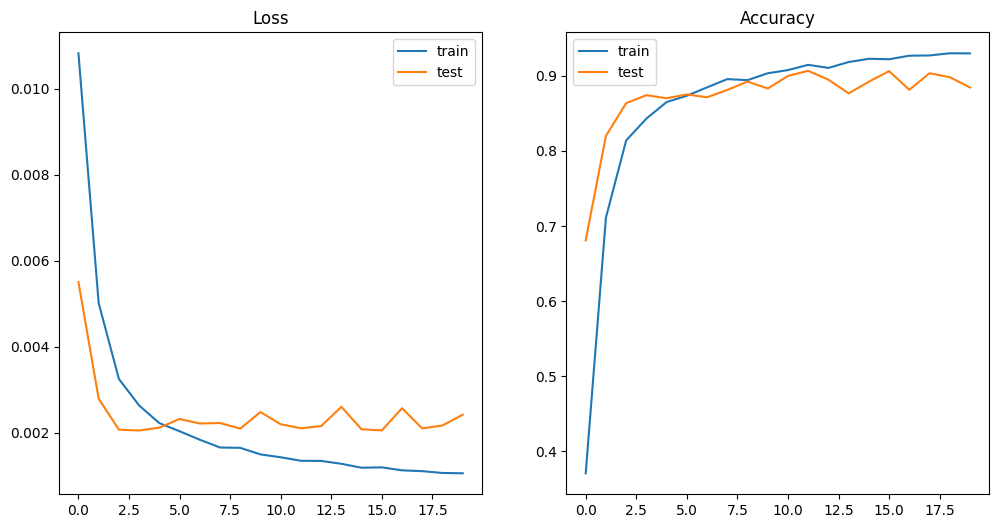

In [25]:
# Посмотрим прогресс обучения на графиках
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

In [27]:
# Сохраним модель
state = {'model': model.state_dict(),
        'epoch': 20}
torch.save(state, '../models/myconvnet_sign_lang.pth')

## Посмотрим как модель предсказывает

In [28]:
testiter = iter(test_loader)
img, label = next(testiter)
model = model.cpu()

Fact: 22, Prediction: 20
tensor(22)


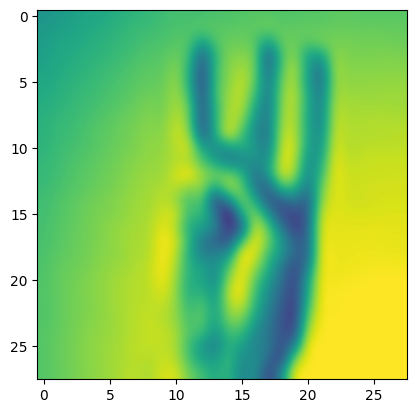

In [29]:
idx=12
pred = model(img)
print(f'Fact: {label[idx]}, Prediction: {(torch.argmax(pred[idx], dim=0))}')
show_img(img[idx], label[idx])

1. DataLoader создаётся через метод _make_dataloader c параметром shuffle. По лучшим практикам:

- Для обучения – shuffle должно быть включено.

- Для валидации и тестирования – shuffle должно быть отключено.


2. Persistent workers.

Добавление persistent_workers=True повышает скорость загрузки данных, если используется несколько воркеров.

3. Логирование метрик с помощью torchmetrics


### Запись файла для сдачи на Stepik

In [5]:
%%writefile homework03.py
#!/usr/bin/env python
import argparse
from io import BytesIO
from zipfile import ZipFile
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict, Any
import torch.utils.data as data
import os

import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import lightning as pl
from lightning import Trainer, LightningModule, LightningDataModule# Джентельменский наборчик
from lightning.pytorch.callbacks import  ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from torchmetrics import Metric
import torchmetrics as tm

# your code here
@dataclass
class CFG:
    seed: int = 2025
    accelerator: str = "auto"  # Автоматическое определение
    devices: int = 1
    dropout: float = 0.3
    lr: float = 1e-3
    batch_size: int = 200
    test_size: float = 0.2
    num_workers: int = min(2, os.cpu_count())
    epochs: int = 10
    gpus: int = 2
    stride: int = 1
    dilation: int =1
    n_classes: int =25
    model_name : str = "myconvnet2_sign_lang.pth"
        
    def __post_init__(self):
        pl.seed_everything(self.seed)
        # Автоматическое определение доступных устройств
        if torch.cuda.is_available():
            self.accelerator = "gpu"
            self.devices = torch.cuda.device_count()
        else:
            self.accelerator = "cpu"
            self.devices = 1

# FDR
class FalseDiscoveryRate(Metric):
    def __init__(self, num_classes:int, average: str = "macro"):
        super().__init__()

        self.num_classes = num_classes
        self.average = average

        self.add_state("fp", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("tp", default=torch.zeros(num_classes), dist_reduce_fx="sum")

    
    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = torch.argmax(preds, dim=1)

        for class_idx in range(self.num_classes):
            pred_is_class = preds == class_idx
            true_is_class = target == class_idx

            self.fp[class_idx] += torch.sum(pred_is_class & ~true_is_class)
            self.tp[class_idx] += torch.sum(pred_is_class & true_is_class)
            

    def compute(self):
        denom = self.fp + self.tp

        fdr = torch.where(denom>0, self.fp / denom, torch.zeros_like(denom))
        if self.average == "macro":
            return fdr.mean()

        elif self.average == "micro":
            return self.fp.sum() / (self.fp.sum() + self.tp.sum())
        
# Dataset
class SignLanguageDataset(data.Dataset):

    
    def __init__(self, df, transform: Optional[transforms.Compose] = None, is_train: bool = True):
        
        self.df = df
        self.transform = transform
        self.is_train = is_train

        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label

# Data Module
class SignLanguageDataModule(LightningDataModule):
    
    def __init__(self, cfg: CFG):
        super().__init__()
        
        self.cfg = cfg
        self.train_transform = transforms.Compose([
        #transforms.Normalize(159, 40),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.RandomApply([transforms.RandomRotation(degrees=(-180, 180))], p=0.2),
    ])
            
    def prepare_data(self):
        """Download and prepare data (called once)"""
        self.train_df = self._read_zip_csv(
            "https://github.com/a-milenkin/ml_instruments/raw/main/data/sign_mnist_train.csv.zip"
        )
        self.test_df = self._read_zip_csv(
            "https://github.com/a-milenkin/ml_instruments/raw/main/data/sign_mnist_test.csv.zip"
        )


    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df, val_df = train_test_split(
                self.train_df, 
                test_size=self.cfg.test_size,
                stratify=self.train_df.iloc[:, 0]
            )
            
            self.train = SignLanguageDataset(train_df, self.train_transform)
            self.val = SignLanguageDataset(val_df, is_train=False)
            
        if stage == "test" or stage is None:
            self.test = SignLanguageDataset(self.test_df, is_train=False)
                     
    def _make_dataloader(self, dataset, shuffle: bool = True):
        return DataLoader(
            dataset,
            batch_size=self.cfg.batch_size,
            shuffle=shuffle,
            num_workers=self.cfg.num_workers,
            pin_memory=True,
            persistent_workers=True  # Рекомендуется для ускорения загрузки данных
    
        )
    
    def _read_zip_csv(self, url: str) -> pd.DataFrame:
        """Helper to read CSV from ZIP"""
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            raise

        with ZipFile(BytesIO(response.content)) as zip_file:
            csv_files = [f for f in zip_file.namelist() 
                        if f.endswith('.csv') and '__MACOSX' not in f]
            if len(csv_files) != 1:
                raise ValueError(f"Expected 1 CSV, found {len(csv_files)}")
                
            with zip_file.open(csv_files[0]) as f:
                return pd.read_csv(f)
            
    def train_dataloader(self)-> DataLoader:
        # Возвращаем Train Dataloader
        return self._make_dataloader(self.train, shuffle=True)
    
    def val_dataloader(self)-> DataLoader:
        # Возвращаем Valid Dataset
        return self._make_dataloader(self.val, shuffle=False)
        
    def test_dataloader(self) -> DataLoader:
        return self._make_dataloader(self.test, shuffle=False)
    
# Model
class MyConvNetLightning(LightningModule):
    
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.lr = cfg.lr
        self.stride = cfg.stride
        self.dilation = cfg.dilation
        self.n_classes = cfg.n_classes

        # позволяет группировать сразу несколько метрик
        self.train_metrics = tm.MetricCollection({
            "accuracy": tm.Accuracy(task="multiclass", num_classes=self.n_classes),
            "auroc": tm.AUROC(task="multiclass", num_classes=self.n_classes),
            "fdr": FalseDiscoveryRate(num_classes=self.n_classes)
        })
        self.valid_metrics = tm.MetricCollection({
            "accuracy": tm.Accuracy(task="multiclass", num_classes=self.n_classes),
            "auroc": tm.AUROC(task="multiclass", num_classes=self.n_classes),
            "fdr": FalseDiscoveryRate(num_classes=self.n_classes)
        })

        
        
        self.model = nn.Sequential(
            #input=(batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(8),
            # (batch, 8, 28, 28)
            nn.AvgPool2d(2),
            # (batch, 8, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=self.stride, dilation=self.dilation),
            nn.BatchNorm2d(16),
            # (batch, 16, 14, 14)
            nn.AvgPool2d(2),
            # (batch, 16, 7, 7)
            nn.ReLU()
            )
        
        self.lin1 = nn.Linear(in_features=16*7*7, out_features=100)
        # (batch, 100)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(p=cfg.dropout)
        self.lin2 = nn.Linear(100, self.n_classes)
        # (batch, 25)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        
        x = self.model(x)
        x = x.view((x.shape[0], -1))
        x = self.lin1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.lin2(x)
        
        return x



    # унифицировать код training_step и validation_step
    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        return logits, y, loss

    def training_step(self, batch, batch_idx):
        logits, y, loss = self._shared_step(batch)
        self.train_metrics.update(logits, y)
        self.log("train/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        logits, y, loss = self._shared_step(batch)
        self.valid_metrics.update(logits, y)
        self.log("val/loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test/loss", loss, prog_bar=True)
        self.log("test/acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Вычисляем агрегированную метрику и сбрасываем для следующей эпохи
        metrics = self.train_metrics.compute()
        # self.log_dict({f"train/{k}": v for k, v in metrics.items()}, prog_bar=True)
        self.log_dict(metrics, prog_bar=True)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        metrics = self.valid_metrics.compute()
        self.log_dict(metrics, prog_bar=True)
        self.valid_metrics.reset()

    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=2, # Сколько эпох ждать без улучшения
            verbose=True, # Печатать, когда LR меняется
            factor=0.5, # Насколько уменьшить LR (в 2 раза, 0.1 = в 10 раз)
            mode='min', # Что хотим минимизировать (например, val_loss)
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train/loss" # Должно совпадать с логгируемым именем
            }
        }
    
def main(args, cfg):

    dataset = SignLanguageDataModule(cfg)
    dataset.prepare_data()
    dataset.setup("fit")
    
    model = MyConvNetLightning(cfg)
    
    # Trainer
    trainer = Trainer(
        accelerator=cfg.accelerator,
        max_epochs=cfg.epochs,
        devices=cfg.devices if cfg.accelerator == "gpu" else "auto",
        log_every_n_steps=1,
        check_val_every_n_epoch=2, # Запускаем проверку val-части каждые 2 эпохи
        # val_check_interval=0.2 # Запускать valid проверку каждые 0.2*epochs
        # enable_checkpointing=not args.fast_dev_run, # отключение чекпоинтов в режиме разработки
        fast_dev_run=args.fast_dev_run,
        callbacks=[
            EarlyStopping( # Подключаем EarlyStopping
                monitor='val/loss', # Какую метрику отлавливаем
                patience=3, # Сколько эпох валидации внимательно наблюдаем
                verbose=True, # Вывод как улучшается ил ухудшается метрика
            ),
            ModelCheckpoint( # Сохранение нескольких весов модели
                monitor='val/loss',
                mode="min",
                filename="best-{epoch}-{val_acc:.2f}",
                dirpath=f"../models/{cfg.model_name}", # Сохранение модели
                enable_version_counter=True, # Не затираем старые веса!
                # auto_insert_metric_name=True, # Сохраняем метрики в названии модели
                save_top_k=3 # Сохраняем 3 лучших модели
            )] 
        )
    
    if args.fast_dev_run:
        try:
#             trainer.test(datamodule=dataset, ckpt_path="best")
            trainer.validate(model, datamodule=dataset)
            print("Тестовый прогон успешно пройден")
        except Exception as err:
            print(f"Тестовый прогон завершился с ошибкой {err}")
            return
    else:
        # Полный цикл обучения + тестирование
        trainer.fit(model, datamodule=dataset)
        trainer.test(model, datamodule=dataset) 
        
    
        # Инференс на одном образце
        dataset.setup("test")
        model.eval()
        sample_img, true_label = dataset.test[0]
        sample = sample_img.unsqueeze(0)  # берём первый образец из теста
        with torch.no_grad():
            pred = model(sample)
            predicted_class = pred.argmax(dim=1).item()
            print(f"Инференс на одном примере: Fact: {true_label}, Prediction:{predicted_class}")


if __name__ == "__main__":
    # your code here
    parser = argparse.ArgumentParser()
    
    # определён через action="store_true". При таком способе использования флаг устанавливается в True
    # , если он присутствует, и не требует передачи дополнительного значения. 
    # То есть, для включения режима fast_dev_run достаточно указать просто флаг без параметров.
    parser.add_argument("--fast_dev_run", action="store_true")
    args = parser.parse_args()
                                                                                       
    cfg = CFG()
  
    main(args, cfg)

Overwriting homework03.py


**Проверка работоспособности**

In [ ]:
!python example.py